# MNIST Handwritten Digit Recognition in PyTorch

In this article we'll build a simple convolutional neural network in PyTorch and train it to recognize handwritten digits using the MNIST dataset. Training a *classifier* on the MNIST dataset can be regarded as the *hello world* of image recognition.

![55154820_a43d3eb317_o.jpg](https://nextjournal.com/data/QmcZCUUTqhqGFR4XCx6UjiPfuYjH2aE7an7We2NnvQ9bm9?content-type=image/jpeg&node-id=cc8b4b29-c59f-4cae-a9bf-51888d7388f8&filename=55154820_a43d3eb317_o.jpg&node-kind=file)

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

# Setting up the Environment

We will be using [PyTorch](https://pytorch.org/) to train a convolutional neural network to recognize MNIST's handwritten digits in this article. PyTorch is a very popular framework for deep learning like [Tensorflow](tensorflow.org), [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) and [Caffe2](https://caffe2.ai/). But unlike these other frameworks PyTorch has dynamic execution graphs, meaning the computation graph is created on the fly.

Since there's already a PyTorch environment from another article, we can just transclude it and use it here.

In [1]:
import torch
import torchvision

# Preparing the Dataset

With the imports in place we can go ahead and prepare the data we'll be using. But before that we'll define the hyperparameters we'll be using for the experiment. Here the number of epochs defines how many times we'll loop over the complete training dataset, while `learning_rate` and `momentum` are hyperparameters for the optimizer we'll be using later on.

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

For repeatable experiments we have to set random seeds for anything using random number generation - this means `numpy` and `random` as well! It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting `torch.backends.cudnn.enabled = False`.

Now we'll also need DataLoaders for the dataset. This is where TorchVision comes into play. It let's use load the MNIST dataset in a handy way. We'll use a `batch_size` of 64 for training and size 1000 for testing on this dataset. The values `0.1307` and `0.3081` used for the `Normalize()` transformation below are the global mean and standard deviation of the MNIST dataset, we'll take them as a given here.

TorchVision offers a lot of handy transformations, such as cropping or normalization.

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

PyTorch's `DataLoader` contain a few interesting options other than the dataset and batch size. For example we could use `num_workers > 1` to use subprocesses to asynchronously load data or using pinned RAM (via `pin_memory`) to speed up RAM to GPU transfers. But since these mostly matter when we're using a GPU we can omit them here.

Now let's take a look at some examples. We'll use the `test_loader` for this.

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Ok let's see what one test data batch consists of.

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

So one test data batch is a  tensor of shape: [reference](#nextjournal#reference#3e383ae1-aa7c-4289-9256-3a41ca01f830). This means we have 1000 examples of 28x28 pixels in grayscale (i.e. no rgb channels, hence the one). We can plot some of them using matplotlib.

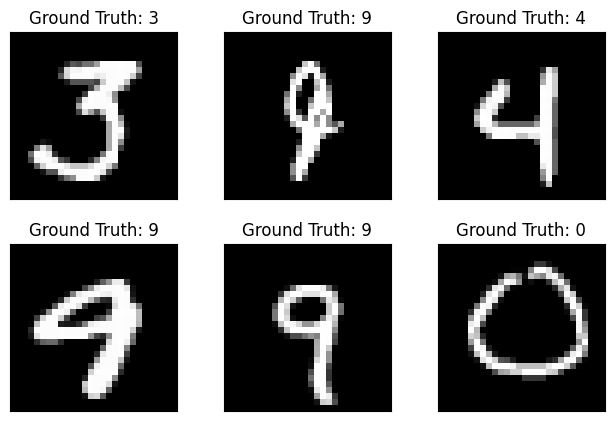

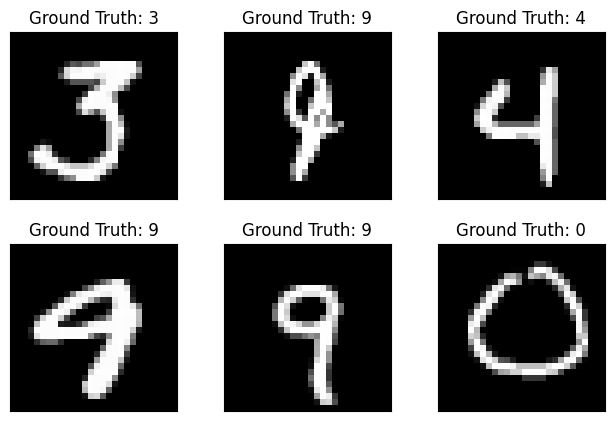

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Alright, those shouldn't be too hard to recognize after some training.

# Building the Network

Now let's go ahead and build our network. We'll use two 2-D convolutional layers followed by two fully-connected (or *linear)* layers. As activation function we'll choose [rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. Let's import a few submodules here for more readable code.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Broadly speaking we can think of the `torch.nn` layers as which contain trainable parameters while `torch.nn.functional` are purely functional. The `forward()` pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

Now let's initialize the network and the optimizer.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Note: If we were using a GPU for training, we should have also sent the network parameters to the GPU using e.g. `network.cuda()`. It is important to transfer the network's parameters to the appropriate device before passing them to the optimizer, otherwise the optimizer will not be able to keep track of them in the right way.

# Training the Model

Time to build our training loop. First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using `optimizer.zero_grad()` since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The `backward()` call we now collect a new set of gradients which we propagate back into each of the network's parameters using `optimizer.step()`. For more detailed information about the inner workings of PyTorch's automatic gradient system, see [the official docs for autograd](https://pytorch.org/docs/stable/notes/autograd.html#) (highly recommended).

We'll also keep track of the progress with some printouts. In order to create a nice training curve later on we also create two lists for saving training and testing losses. On the x-axis we want to display the number of training examples the network has seen during training. 

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters. Can you guess what our accuracy might look like for this case?

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data, target = data.to(device), target.to(device)
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

Neural network modules as well as optimizers have the ability to save and load their internal state using `.state_dict()`. With this we can continue training from previously saved state dicts if needed - we'd just need to call `.load_state_dict(state_dict)`. 

Now for our test loop. Here we sum up the test loss and keep track of correctly classified digits to compute the accuracy of the network. 

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using the context manager `no_grad()` we can avoid storing the computations done producing the output of our network in the computation graph.

Time to run the training! We'll manually add a `test()` call before we loop over n_epochs to evaluate our model with randomly initialized parameters.

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_26199/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331797
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.303324
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.266475
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.272787
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.261453
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.231299
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.225890
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.222582
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.114449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.042787
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.954830
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.993595
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.803929
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.503879
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.451350
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.506524
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.314457
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.360069
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.430165
Train Epoch: 1 [12160/6

# Evaluating the Model's Performance

And that's it. With just 3 epochs of training we already managed to achieve 97% accuracy on the test set! We started out with randomly initialized parameters and as expected only got about 10% accuracy on the test set before starting the training.

Let's plot our training curve.

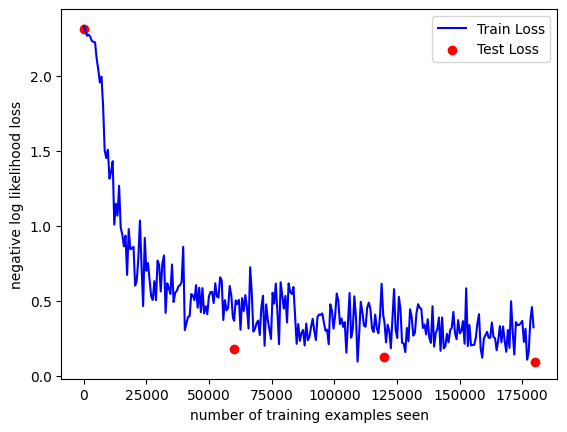

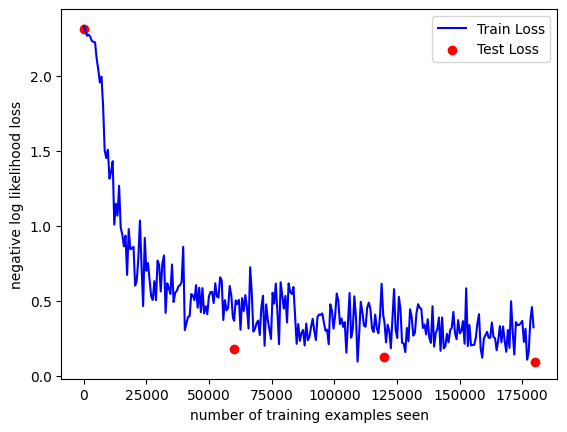

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Judging from the *training curve* ([reference](#nextjournal#reference#31a9f56f-a52a-4df0-9f58-729c877329ff)) it looks like we could even continue training for a few more epochs!

But before that let's again look at a few examples as we did earlier and compare the model's output.

In [15]:
with torch.no_grad():
  output = network(example_data.to(device))

/tmp/ipykernel_26199/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


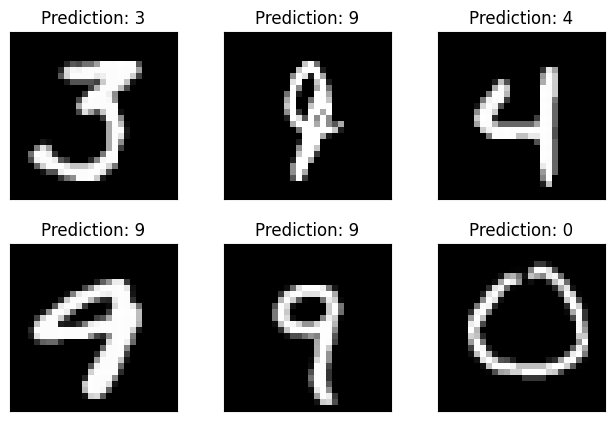

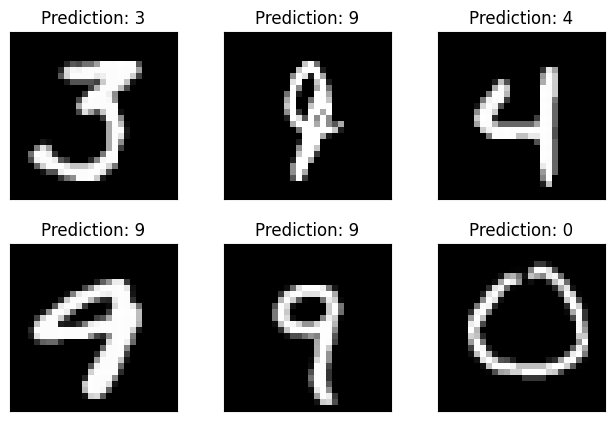

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

Our model's predictions seem to be on point for those examples!

# Continued Training from Checkpoints

Now let's continue training the network, or rather see how we can continue training from the state_dicts we saved during our first training run. We'll initialize a new set of network and optimizers.

In [17]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

Using `.load_state_dict()` we can now load the internal state of the network and optimizer when we last saved them.

In [18]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [19]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/tmp/ipykernel_26199/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.124422
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.200896
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.279778
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.243456
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.189900
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.279645
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.540901
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.344222
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.244146
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.153191
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.319916
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.246731
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.365626
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.258753
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.190660
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.485843
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.405539
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.185692
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.157416
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.388889
Train Epoch: 4 [12800/60000 (

Great! We again see a (much slower) increase in test set accuracy from epoch to epoch. Let's visualize this to further inspect the training progress.

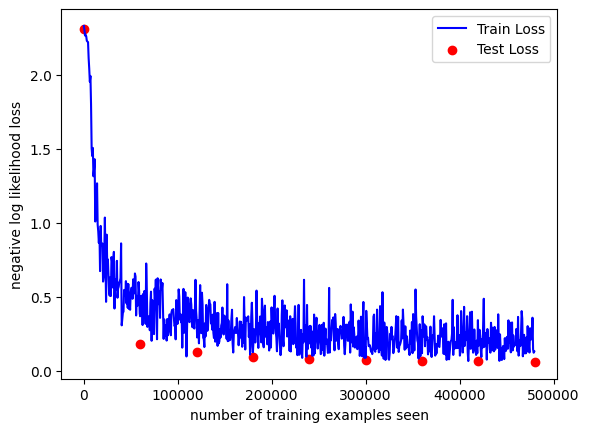

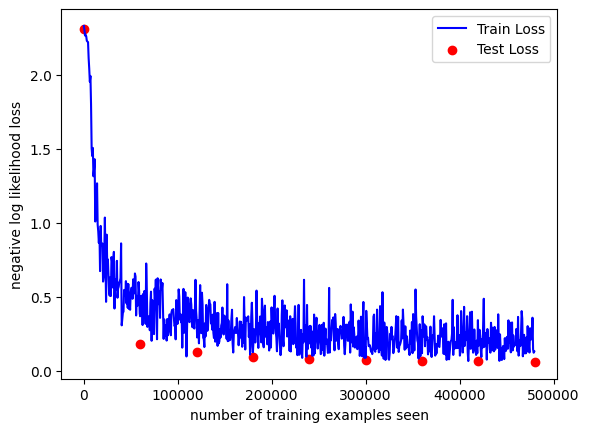

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

That still looks like a rather smooth learning curve just as if we initially would've trained for 8 epochs! Remember that we just appended values to the same lists starting from the 5th red dot onward.

From this we can conclue two things:

1\. Continuing from the checkpointed internal state worked as intended.

2\. We still don't seem to run into overfitting issues! It looks like our dropout layers did a good job regularizing the model.

In summary we built a new environment with PyTorch and TorchVision, used it to classifiy handwritten digits from the MNIST dataset and hopefully developed a good intuition using PyTorch. For further information the official [PyTorch documentation](https://pytorch.org/docs/stable/index.html) is really nicely written and the [forums](https://discuss.pytorch.org/) are also quite active!